In [1]:
import difflib
import json
import os
import random
import re

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from alive_progress import alive_bar
from sentence_transformers import SentenceTransformer, util

from language_classifier.language_classifier import LanguageClassifier

# formatting
pd.set_option('display.float_format', '{:.1f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

In [2]:
# folders
parsed_docs_folder = os.path.join("..", "ParsedPublications")
fr_eng_correlation_csv = "fr_eng_correlation_data.csv"

fr_eng_correlation_df = pd.read_csv(fr_eng_correlation_csv)

# weblinks for previewing / testing
weblinks_df = fr_eng_correlation_df.copy()
weblinks_df = weblinks_df[['pub_number', 'nom', 'name', 'url_fr', 'url_en', 'file_url_fr', 'file_url_en']]

# simplified correlation table
fr_eng_correlation_df = fr_eng_correlation_df[['pub_number', 'filename_fr', 'filename_en']]

# read in matched data
corpus_df = pd.read_pickle("matched_data.pickle")

In [3]:
corpus_df.shape

(787468, 3)

In [4]:
corpus_df.sample(22)

,pub_number,fr,en
712073,SCR 2020/048,"Pour l illustrer, une moyenne géométrique sur trois ans des indices de biomasse dans les strates...","The -yr GM of biomass indices in Strata Z Z Z , which includes the adjacent Fundian Channel stra..."
760786,SSR 1999/C3-63,"En , le nombre moyen de pétoncles de mm a doublé par rapport à celui observé en","In , the mean number of scallops mm doubled over that observed in"
317170,RES 2020/029,Il est possible d en déduire que la mortalité imputable à la remise à l eau du poisson capturé e...,This suggests that catch and release mortality is highly variable (even on a regional scale) amo...
651040,SAR 2024/010,"Comme pour toutes les données dépendantes de la pêche, l information sur la répartition spatiale...","As with all fishery-dependent data, the information on spatial distribution is more indicative o..."
611322,SAR 2019/016,Région des Maritimes Site d intérêt des îles de la côte Est La merluche blanche (Urophycis tenui...,White Hake (Urophycis tenuis) are a demersal species found on the continental shelf and upper co...
596913,SAR 2017/053,"Composition chimique Saturés, aromatiques, résines et asphaltènes (SARA) COV, y compris les BTEX...","Chemical composition Saturates, aromatics, resins, and asphaltenes (SARA) VOCs including BTEX, T..."
79174,PRO 2012/023,Étude de l'importance \ndes facteurs utilisés au cours des estimations \nde la biomasse pour le ...,"Study of the importance of factors \nused during biomass estimates for snow \ncrab, Chionoecetes..."
414918,RES 2022/074,Les données de sont préliminaires,Data for are preliminary
554468,SAR 2013/016,"Cependant, les pêcheurs sont d avis qu un poids de kg serait plus réaliste","However, fishers find that a weight of kg is more realistic"
565435,SAR 2014/021,Les domaines vitaux en eau douce sont abandonnés lorsque les présaumoneaux et les saumoneaux amo...,Home ranges in freshwater are abandoned when pre-smolt and smolt begin to migrate to the marine ...


In [5]:
memory_usage_mb = corpus_df.memory_usage(deep=True).sum() / (1024 ** 2)

f"DataFrame size: {memory_usage_mb:.1f} MB"

'DataFrame size: 373.8 MB'

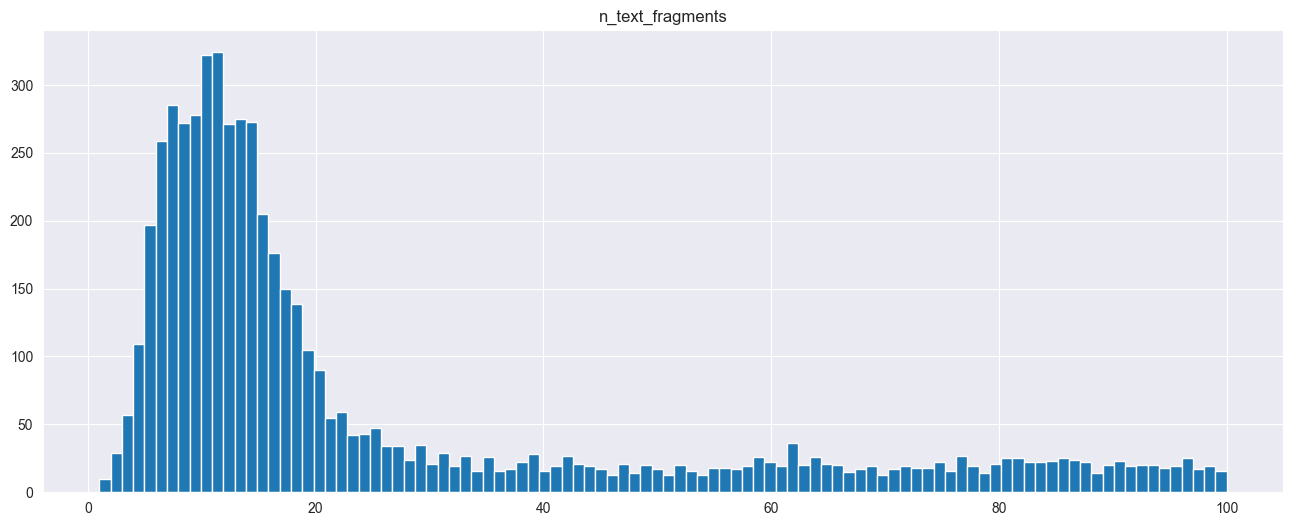

In [21]:
# this is because of a messed up inequality in the data creation algorithm, no abstract only translations were excluded

corpus_value_counts = pd.DataFrame(corpus_df.pub_number.value_counts())
corpus_value_counts.columns = ['n_text_fragments']
corpus_value_counts[corpus_value_counts.n_text_fragments <= 100].hist(bins=100, figsize=(16, 6));

['RES 1999/147',
 'RES 1999/116',
 'RES 1999/192',
 'RES 2014/006',
 'RES 2012/071',
 'RES 2012/095',
 'RES 2015/074',
 'RES 2000/117',
 'RES 2000/158',
 'RES 2000/081',
 'RES 2003/027',
 'RES 2007/050',
 'RES 2015/076',
 'RES 2012/153',
 'RES 1999/054',
 'RES 2001/005',
 'SCR 2008/010',
 'RES 2012/110',
 'RES 2012/152',
 'RES 2002/122',
 'RES 2012/142',
 'RES 1995/055',
 'RES 1995/096',
 'RES 1995/128',
 'RES 2002/074',
 'RES 2002/072',
 'RES 2002/036',
 'RES 2002/024',
 'RES 2017/010',
 'RES 2002/017',
 'RES 1990/009',
 'RES 2001/155',
 'RES 1997/074',
 'RES 2001/110',
 'RES 1998/029',
 'RES 1998/037',
 'RES 1998/047',
 'SAR 2005/049',
 'RES 1998/066',
 'RES 2001/062',
 'RES 1999/023',
 'RES 1999/026',
 'RES 2012/093',
 'RES 2001/010',
 'RES 2014/086',
 'RES 2017/027',
 'RES 2000/085',
 'RES 2010/069',
 'SSR 1996/011',
 'RES 2004/055',
 'RES 2009/098',
 'RES 2012/020',
 'PRO 2008/022',
 'RES 2004/036',
 'RES 2006/040',
 'RES 2005/005',
 'RES 2004/134',
 'RES 2004/133',
 'PRO 2012/050

In [8]:
# TODO: clean up text fragments?